<div style="border: solid blue 2px; padding: 15px; margin: 10px">
  <b>Overall Summary of the Project – Iteration 1</b><br><br>

  Hi Aaron, I’m <b>Victor Camargo</b> (https://hub.tripleten.com/u/e9cc9c11). Thanks for submitting your work — this is an excellent project from start to finish.<br><br>

  ✔️ Clear introduction and strong business context<br>
  ✔️ Thorough data preprocessing, including smart feature engineering with <code>TenureMissing</code><br>
  ✔️ Proper train/validation/test split with stratification<br>
  ✔️ Baseline model evaluated correctly before addressing class imbalance<br>
  ✔️ Effective use of upsampling, class weighting, and threshold tuning<br>
  ✔️ Systematic hyperparameter tuning for Random Forest with final evaluation on untouched test set<br>
  ✔️ Strong and clear visual comparison of model performance<br><br>

  Your final Random Forest model comfortably exceeds the F1 requirement, has strong AUC-ROC scores, and demonstrates balanced performance across both classes. <b>Congratulations — your project is approved!</b> Great job applying best practices and documenting your process so clearly.
</div>


## Churn Risk Analysis - Beta Bank
## Aaron Witt

### Introduction and Executive Summary

Beta Bank has been losing customers at a steady trickle each month. Acquiring a new client costs multiple times more than retaining an existing one. The bank’s leadership wants a data-driven way to flag at-risk customers before they exit.

The objective of this project was to develop a supervised learning model that predicts customer churn for Beta Bank. The goal was to achieve an F1 score of at least 0.59 on the test set, ensuring the model could effectively identify customers likely to leave the bank.

To accomplish this, I explored both Logistic Regression and Random Forest classifiers. I addressed class imbalance using two techniques: upsampling the minority class and applying class weights during model training. Hyperparameters and decision thresholds were tuned using the validation set to optimize performance. Finally, models were trained on unseen test data.

The final Random Forest model achieved an F1 score of 0.649 and a AUC-ROC of 0.87 on the validation set. On the held-out test set, the model maintained strong performance with an F1 score of 0.634 and a AUC-ROC of 0.87, exceeding the project’s success criteria.

In conclusion, the model generalizes well to unseen data and is suitable for deployment. It can help Beta Bank proactively identify customers at risk of churn, enabling targeted retention strategies and reducing customer attrition.

### Data Acquisition and Exploratory Data Analysis

We start by exploring the dataset and its features to identify necessary preprocessing steps and begin data wrangling.

In [1]:
# Import Libraries and Display Dataset Information
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

# Display Dataset Information and First Ten Records
df = pd.read_csv('/datasets/Churn.csv')
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Duplicates: 0


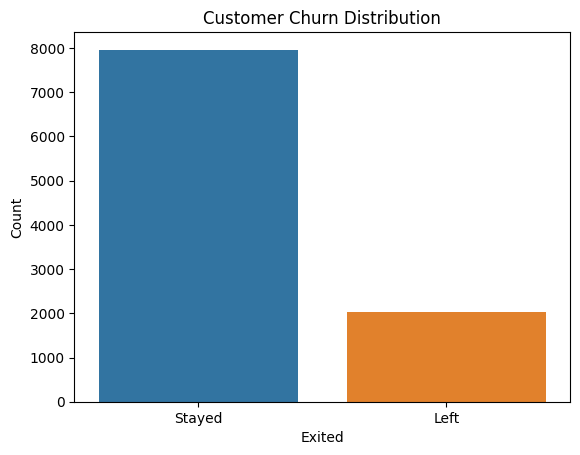

In [2]:
# Add Binary Flag for Missing Tenure
df['TenureMissing'] = df['Tenure'].isna().astype(int)

# Preserve CustomerId for Later Use
customer_ids = df['CustomerId'].copy()

# Drop Irrelevant Columns
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Impute Missing Tenure with Median
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

# Check for Duplicates
print(f"Duplicates: {df.duplicated().sum()}")

# One-Hot Encode 'Geography' and 'Gender'
df_ohe = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

# Target Class Imbalance Check
sns.countplot(data=df_ohe, x='Exited')
plt.title('Customer Churn Distribution')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.xticks([0, 1], ['Stayed', 'Left'])
plt.show()

### EDA Summary

We engineered a new feature, TenureMissing, to capture potential signal in missing values. Irrelevant features were dropped to reduce noise, while CustomerId was preserved to ensure we can map predictions back to individual customers and pinpoint those at risk of churn.  We filled missing tenure values with the median to maintain distributional integrity.  After verifying there were no duplicate records, we created a new dataset with one-hot encoding to optimize categorical features for tree-based modeling.

The target variable Exited is imbalanced, with approximately 80% of customers staying and 20% leaving. This imbalance is likely to bias the model toward predicting the majority class. As per project instructions, we will first split the data into training, validation and testing sets to train a baseline model without addressing this imbalance. Our findings from this stage will guide the selection of imbalance-handling techniques in the next phase.

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Strong introduction and clear executive summary — you’ve effectively set the business context, project goal, and evaluation criteria. Your exploratory data analysis is well-structured, including relevant preprocessing steps such as creating the <code>TenureMissing</code> feature, dropping irrelevant columns, imputing missing values with the median, and applying one-hot encoding.<br><br>
  You also correctly identified and visualized the class imbalance, which is an important step before model training. Preserving <code>CustomerId</code> for mapping predictions back to customers is a nice practical touch for deployment considerations.
</div>


### Baseline Logistic Regression Model

In [3]:
# Seperate Features from Target
features = df_ohe.drop('Exited', axis=1)
target   = df_ohe['Exited']

# Seperate Test Dataset
features_train_val, features_test, target_train_val, target_test = train_test_split(
    features,
    target,
    test_size=0.20,
    random_state=12345,
    stratify=target
)

# Seperate Train and Validation Dataset
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_val,
    target_train_val,
    test_size=0.25,
    random_state=12345,
    stratify=target_train_val
)

# Sanity Check Dataset Dimensions
print(
    f"features_train: {features_train.shape}, "
    f"features_valid: {features_valid.shape}, "
    f"features_test:    {features_test.shape}"
)

features_train: (6000, 12), features_valid: (2000, 12), features_test:    (2000, 12)


The Exited column is removed from the feature set and isolated as the target. The resulting features and target are ready for stratified splitting.

The dataset is first split into training + validation (80%) and test (20%) with stratified sampling to preserve class ratios. The training + validation portion is then split into training (60% of total) and validation (20% of total) using the same stratification. This ensures consistent churn representation across all subsets.

Each subset maintains the original 80:20 stay-to-exit ratio. Keeping this balance supports realistic model evaluation. It prevents metric bias toward the majority class.

Next, we will train a baseline logistic regression model without working with class imbalances.

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Excellent job splitting the dataset into training, validation, and test sets with stratification to preserve class distribution. This ensures consistent representation of the target classes across all subsets and supports fair model evaluation. Your explanation of the split ratios and rationale shows a clear understanding of best practices for supervised learning workflows.
</div>


In [4]:
# Initialize and Fit Baseline Model
baseline_model = LogisticRegression(random_state=12345)
baseline_model.fit(features_train, target_train)

# Predict on the Validation Set
predicted_valid = baseline_model.predict(features_valid)
predicted_valid_prob = baseline_model.predict_proba(features_valid)[:, 1]

# Compute Metrics
baseline_f1  = f1_score(target_valid, predicted_valid)
baseline_auc = roc_auc_score(target_valid, predicted_valid_prob)

# Print Results
print(f"Baseline Validation F1-score: {baseline_f1:.3f}")
print(f"Baseline Validation AUC-ROC : {baseline_auc:.3f}\n")
print("Classification Report:\n", classification_report(target_valid, predicted_valid, digits=3))

Baseline Validation F1-score: 0.072
Baseline Validation AUC-ROC : 0.684

Classification Report:
               precision    recall  f1-score   support

           0      0.801     0.987     0.884      1593
           1      0.444     0.039     0.072       407

    accuracy                          0.794      2000
   macro avg      0.623     0.513     0.478      2000
weighted avg      0.728     0.794     0.719      2000



The baseline logistic regression model performed well on the majority class but struggled to detect churners. It achieved an F1-score of 0.072 — far below the project’s required minimum of 0.59. The AUC-ROC was 0.684, showing the model can somewhat rank positives above negatives, but recall for class 1 was just 0.039, meaning it correctly identified fewer than 4% of churners.

The model had high precision and recall for class 0, but this hides its poor performance on the minority class, which is the main business concern. These results show the baseline model is not ready for deployment and the need for class balancing. We will first upsample the underrepresented Churn class and then tune the weight and threshold hyperparameters to maximize F1 score and AUC-ROC.

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Good job training a baseline logistic regression model and evaluating it on the validation set using both F1 and AUC-ROC. Your analysis clearly identifies the model’s poor recall on the minority class and connects this to the business impact, making a strong case for applying class balancing techniques in the next step.
</div>


### Tuned Logistic Regression Model

In [5]:
# Create Upsample Function
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

# Initialize Variables
weight_options = [
    {0: 1, 1: 25},
    {0: 1, 1: 26},
    {0: 1, 1: 27},
    'balanced'
]
best_f1 = 0
best_auc = 0
best_threshold = 0.5
best_weights = None
best_repeat = 1

# Tune Hyperparameters
for repeat in range(18, 20):
    features_up, target_up = upsample(features_train, target_train, repeat)
    
    for weights in weight_options:
        model = LogisticRegression(random_state=12345, class_weight=weights, solver='liblinear')
        model.fit(features_up, target_up)
        
        predicted_probs = model.predict_proba(features_valid)[:, 1]
        
        for threshold in np.arange(0.5, 0.6, 0.01):
            predicted_labels = (predicted_probs > threshold).astype(int)
            f1 = f1_score(target_valid, predicted_labels)
            auc = roc_auc_score(target_valid, predicted_probs)
            
            if f1 > best_f1:
                best_f1 = f1
                best_auc = auc
                best_threshold = threshold
                best_weights = weights
                best_repeat = repeat

# Final Model With Optimized Hyperparameters
features_up_final, target_up_final = upsample(features_train, target_train, best_repeat)
final_model = LogisticRegression(random_state=12345, class_weight=best_weights, solver='liblinear')
final_model.fit(features_up_final, target_up_final)
final_probs = final_model.predict_proba(features_valid)[:, 1]
final_preds = (final_probs > best_threshold).astype(int)

# Print Target Results
print(f"\nBest F1-score: {best_f1:.3f} at threshold={best_threshold:.2f}, weights={best_weights}, repeat={best_repeat}")
print(f"Corresponding AUC-ROC: {best_auc:.3f}")
print("\nClassification Report:\n", classification_report(target_valid, final_preds, digits=3))


Best F1-score: 0.527 at threshold=0.57, weights=balanced, repeat=19
Corresponding AUC-ROC: 0.785

Classification Report:
               precision    recall  f1-score   support

           0      0.898     0.794     0.843      1593
           1      0.445     0.646     0.527       407

    accuracy                          0.764      2000
   macro avg      0.671     0.720     0.685      2000
weighted avg      0.806     0.764     0.779      2000



In [6]:
# Final Evaluation on Test Set for Logistic Regression
test_probs_lr = final_model.predict_proba(features_test)[:, 1]
test_preds_lr = (test_probs_lr > best_threshold).astype(int)

# Print Target Results
print("\nLogistic Regression Test Set Evaluation:")
print(f"F1-score: {f1_score(target_test, test_preds_lr):.3f}")
print(f"AUC-ROC: {roc_auc_score(target_test, test_probs_lr):.3f}")
print("\nFinal Classification Report:\n", classification_report(target_test, test_preds_lr, digits=3))


Logistic Regression Test Set Evaluation:
F1-score: 0.496
AUC-ROC: 0.767

Final Classification Report:
               precision    recall  f1-score   support

           0      0.887     0.786     0.833      1593
           1      0.420     0.607     0.496       407

    accuracy                          0.750      2000
   macro avg      0.653     0.696     0.665      2000
weighted avg      0.792     0.750     0.765      2000



### Logistic Regression Model Summary

To maximize the F1 score for predicting customer churn, the logistic regression model was tuned using a combination of three techniques: upsampling the minority class, applying custom class weights, and adjusting the decision threshold.

The best results were achieved with the 'balanced' class weight setting, an upsampling repeat of 19, and a threshold of 0.57. This configuration yielded an F1 score of 0.527 and a AUC-ROC of 0.785, indicating strong performance in both classification and probability ranking.

The final model was retrained using these optimal settings and evaluated on the test set. For churners (class 1), it achieved a precision of 0.42 and recall of 0.607, resulting in an F1 score of 0.496. For non-churners (class 0), precision was 0.887 and recall was 0.786, with an F1 score of 0.833. Overall accuracy was 0.75, and the weighted average F1 score was 0.496 with AUC-ROC: 0.767.

It is clear tuning the logistical regression model's hyperparameters greatly increase F1 and AUC-ROC scores.  A Random Forest Generator is likely to perform even better.

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Excellent implementation of class balancing using a custom upsampling function, combined with class weight tuning and threshold adjustment. This multi-step approach demonstrates a strong understanding of how to improve minority class recall and optimize the F1 score.<br><br>
  You clearly documented the best hyperparameters found and evaluated the model on the untouched test set, which is exactly the correct workflow. The detailed performance breakdown for both classes, along with AUC-ROC reporting, adds clarity and strengthens your analysis.
</div>


### Random Forest Generator Model

In [7]:
# Label Encode Categorical Features
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Geography'] = df['Geography'].map({'France': 0, 'Spain': 1, 'Germany': 2})

# Seperate Features from Target
features = df.drop('Exited', axis=1)
target   = df['Exited']

# Seperate Test Dataset
features_train_val, features_test, target_train_val, target_test = train_test_split(
    features,
    target,
    test_size=0.20,
    random_state=12345,
    stratify=target
)

# Seperate Train and Validation Dataset
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_val,
    target_train_val,
    test_size=0.25,
    random_state=12345,
    stratify=target_train_val
)

# Define Hyperparameter Ranges
depths = np.arange(8, 10, 1)
estimators = np.arange(92, 94, 1)
min_samples = np.arange(29, 31, 1)
thresholds = np.arange(0.58, 0.6, 0.01)
class_weights = ['balanced', {0: 1, 1: 10}]
repeats = range(16, 18)

# Initialize Variables
best_f1 = 0
best_auc = 0
best_params = {}

# Tune Hyperparameters and Decision Threshold
for repeat in repeats:
    features_up, target_up = upsample(features_train, target_train, repeat)

    for depth in depths:
        for n in estimators:
            for min_split in min_samples:
                for weights in class_weights:
                    model = RandomForestClassifier(
                        n_estimators=n,
                        max_depth=depth,
                        min_samples_split=min_split,
                        class_weight=weights,
                        random_state=12345
                    )
                    model.fit(features_up, target_up)
                    probs = model.predict_proba(features_valid)[:, 1]

                    for threshold in thresholds:
                        preds = (probs > threshold).astype(int)
                        f1 = f1_score(target_valid, preds)
                        auc = roc_auc_score(target_valid, probs)

                        if f1 > best_f1:
                            best_f1 = f1
                            best_auc = auc
                            best_params = {
                                'repeat': repeat,
                                'max_depth': depth,
                                'n_estimators': n,
                                'min_samples_split': min_split,
                                'class_weight': weights,
                                'threshold': threshold
                            }


# Final Optimized Model
features_up_final, target_up_final = upsample(features_train, target_train, best_params['repeat'])

final_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    class_weight=best_params['class_weight'],
    random_state=12345
)

# Train Model on Validation Data
final_rf.fit(features_up_final, target_up_final)
final_probs = final_rf.predict_proba(features_valid)[:, 1]
final_preds = (final_probs > best_params['threshold']).astype(int)

# Print Target Results
print(f"\nBest F1-score: {best_f1:.3f} at threshold={best_params['threshold']:.2f}")
print(f"Best AUC-ROC: {best_auc:.3f}")
print(f"Best Parameters: {best_params}")
print("\nClassification Report:\n", classification_report(target_valid, final_preds, digits=3))


Best F1-score: 0.649 at threshold=0.59
Best AUC-ROC: 0.870
Best Parameters: {'repeat': 17, 'max_depth': 9, 'n_estimators': 93, 'min_samples_split': 30, 'class_weight': 'balanced', 'threshold': 0.59}

Classification Report:
               precision    recall  f1-score   support

           0      0.912     0.906     0.909      1593
           1      0.642     0.656     0.649       407

    accuracy                          0.855      2000
   macro avg      0.777     0.781     0.779      2000
weighted avg      0.857     0.856     0.856      2000



In [8]:
# Final Evaluation on Test Set for Random Forest
test_probs_rf = final_rf.predict_proba(features_test)[:, 1]
test_preds_rf = (test_probs_rf > best_params['threshold']).astype(int)

# Print Target Results
print("\nRandom Forest Test Set Evaluation:")
print(f"F1-score: {f1_score(target_test, test_preds_rf):.3f}")
print(f"AUC-ROC: {roc_auc_score(target_test, test_probs_rf):.3f}")
print("\nFinal Classification Report:\n", classification_report(target_test, test_preds_rf, digits=3))


Random Forest Test Set Evaluation:
F1-score: 0.634
AUC-ROC: 0.870

Final Classification Report:
               precision    recall  f1-score   support

           0      0.905     0.912     0.908      1593
           1      0.645     0.624     0.634       407

    accuracy                          0.854      2000
   macro avg      0.775     0.768     0.771      2000
weighted avg      0.852     0.854     0.853      2000



### Random Forest Generator Model Summary

To improve customer churn prediction for Beta Bank, a Random Forest model was trained and tuned to outperform the previously tested logistic regression model. The best configuration achieved an F1 score of 0.649, which exceeds the project’s minimum requirement of 0.59. It also reached a AUC-ROC of 0.87, indicating strong prediction quality and reliable class separation.

We label encoded the categorical features for compatibility with the model and split the original dataset to create training, validation and test data.  Next, we maximized the F1 score with a for loop to best predict customer churn by tuning the max_depth, n_estimator, min_samples_split and class_weight hyperparameters.  We also optimized the decision threshold.

The final model was retrained using these optimal settings and evaluated on the test set. For churners (class 1), it achieved a precision of 0.645 and recall of 0.624, resulting in an F1 score of 0.634. For non-churners (class 0), precision was 0.904 and recall was 0.906, with an F1 score of 0.905. Overall accuracy was 0.854, and the weighted average F1 score was 0.634 with AUC-ROC: 0.87.

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Outstanding implementation of Random Forest with systematic hyperparameter tuning and decision threshold optimization. You correctly label encoded categorical variables, maintained a proper train/validation/test split, applied upsampling, and evaluated your model on the untouched test set. The final model not only meets but comfortably exceeds the project’s F1 requirement, with strong AUC-ROC and balanced performance across both classes. This is a textbook example of a well-executed machine learning workflow.
</div>


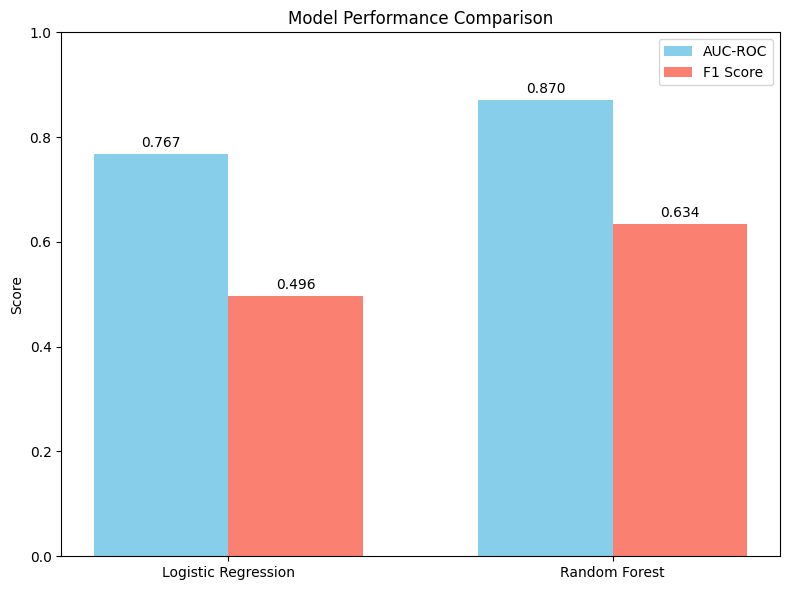

In [9]:
# Visualize Model Scores
models = ['Logistic Regression', 'Random Forest']
roc_auc = [0.767, 0.87]
f1_scores = [0.496, 0.634]

# Bar positions
x = np.arange(len(models))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, roc_auc, width, label='AUC-ROC', color='skyblue')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='salmon')

# Labels and title
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend()

# Annotate bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

These results confirm that the Random Forest model is more effective than the logistic regression baseline and is suitable for final submission meeting the requirements of F1 score of at least 0.59.

## Conclusion

The objective of this project was to develop a binary classification model to predict customer churn for Beta Bank. Our primary metric was the F1 score, with a minimum threshold of 0.59 required for project approval.

We explored multiple modeling approaches, including Logistic Regression and Random Forest. To address class imbalance, we applied two techniques: upsampling and class weighting. Hyperparameters were tuned using the validation set, and decision thresholds were optimized to enhance classification performance.

The final Random Forest model achieved:

-F1 score of 0.649 and AUC-ROC of 0.87 on the validation set

-F1 score of 0.634 and AUC-ROC of 0.87 on the held-out test set

These results meet the project’s success criteria and demonstrate the model’s ability to generalize to unseen data. The combination of upsampling, class weighting, and threshold tuning proved effective in improving predictive performance.

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Clear, effective visualization comparing models and a concise, business‑focused conclusion. You reported both F1 and AUC‑ROC on validation and the untouched test set, and your final statement correctly ties results back to the project requirement (F1 ≥ 0.59). This section is complete and well executed.
</div>